In [2]:
# FNCE/BTEC 494: AI For Financial Modeling
# Spring '24
# Author: Prof. Jay D. Vaidya

# This Jupyter Notebook should serve as an example you can use to build your ML pipelines and undertake your
# modeling; it does NOT, however, represent the requirements for this A2 assignment. Please refer to the A2
# write-up for details on the assignment requirements.

In [3]:
# Let's begin by importing several packages we are likely to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

# We will also be using several SKLearn packages specific to building ML pipelines, as well as those used in
# generating and fitting our models. We will import them here, too.
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [4]:
# Read in our dataset(s), 'train' and 'test'; I have uploaded my datasets to my current session,
# so the filepath used to read in my data will reflect this

train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

# Quick print statement which prints the shape of each DF
print('\n', 'Train dataset shape:', train.shape[0],'x', train.shape[1],'\n'
      'Test dataset shape:', test.shape[0],'x', test.shape[1])


 Train dataset shape: 1460 x 81 
Test dataset shape: 1459 x 80


In [5]:
# Let's look at the head and tail of training dataset
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


### We should immediately take note of the following characteristics of the training data:

*   There are a mixture of 1) Numeric (i.e., interger & real num.); 2) Categorical (i.e., strings with inherent meaning, but not subject to ranking); and 3) Ordinal (strings or numeric data in which the order between categories imparts meaning) data
*   There are a significant number of missing records in some of the features (i.e., columns) which will require attention before we try to fit any models
*   The scale of various numeric features is SIGNIFICANTLY different; this may be an early indication that some form of feature scaling is appropriate



In [7]:
# It is difficult to view all of the columns in the DF format; we can call on the attribute
# 'columns' for the DF in order to get a list of the columns
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
# We use the .info() method to get more information on the types of data and prevalence
# of missing - or null - records in each feature
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### At This point, you should undertake your Exploratory Data Analysis (EDA) before proceeding any further. You may want to answer for yourselves some of the following questions:


1.   What are the distributions of values for your features (are they normally distributed, highy skewed, or mostly missing?)
2.   Are there any significant correlations between variables that may lead to multicollinearity issues? If so - what options may we use to address these issues?
3.   Is it best to retain all of the available features, or is there a good reason to eliminate (i.e. drop) some? If so, why?



In [1]:
## YOUR EDA BEGINS HERE!!! ##
## Generate as many new code cells as needed, below, to undertake your EDA ##

## High Impact features

In [11]:
# Check missing values percentage
missing_values = train.isnull().sum() / len(train) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

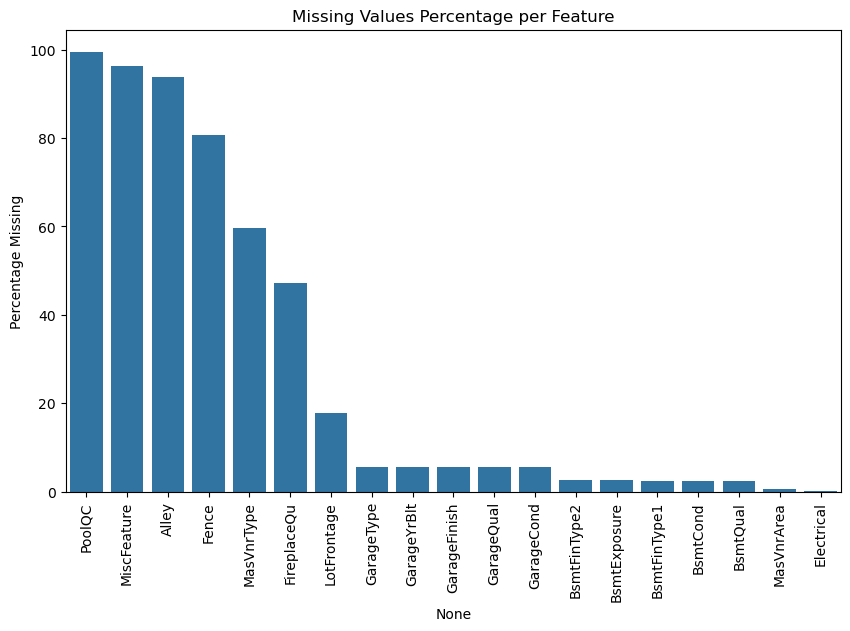

In [12]:
# Plot missing values
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.xticks(rotation=90)
plt.ylabel("Percentage Missing")
plt.title("Missing Values Percentage per Feature")
plt.show()


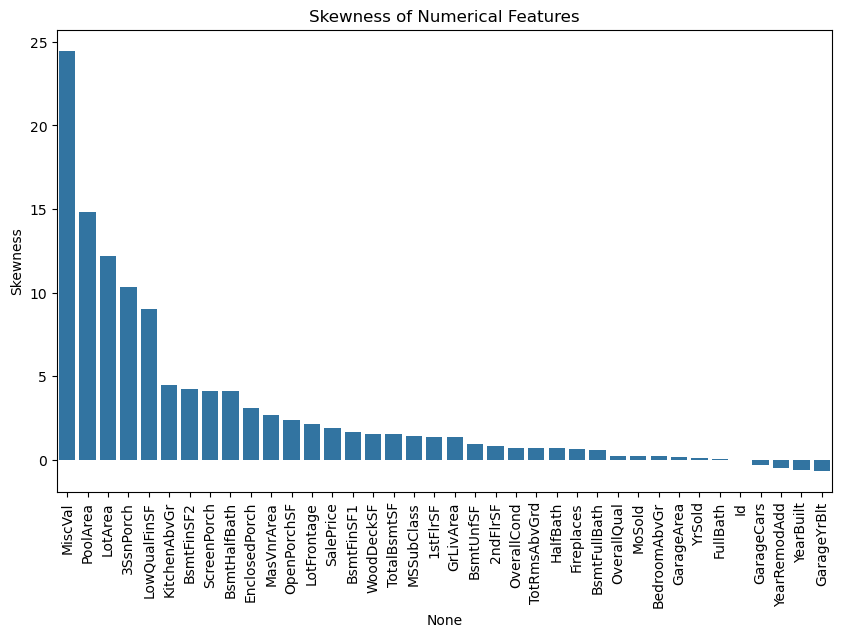

In [13]:
# Check skewness of numerical features
numerical_features = train.select_dtypes(include=[np.number]).columns
skewness = train[numerical_features].skew().sort_values(ascending=False)

# Plot skewness
plt.figure(figsize=(10, 6))
sns.barplot(x=skewness.index, y=skewness.values)
plt.xticks(rotation=90)
plt.ylabel("Skewness")
plt.title("Skewness of Numerical Features")
plt.show()

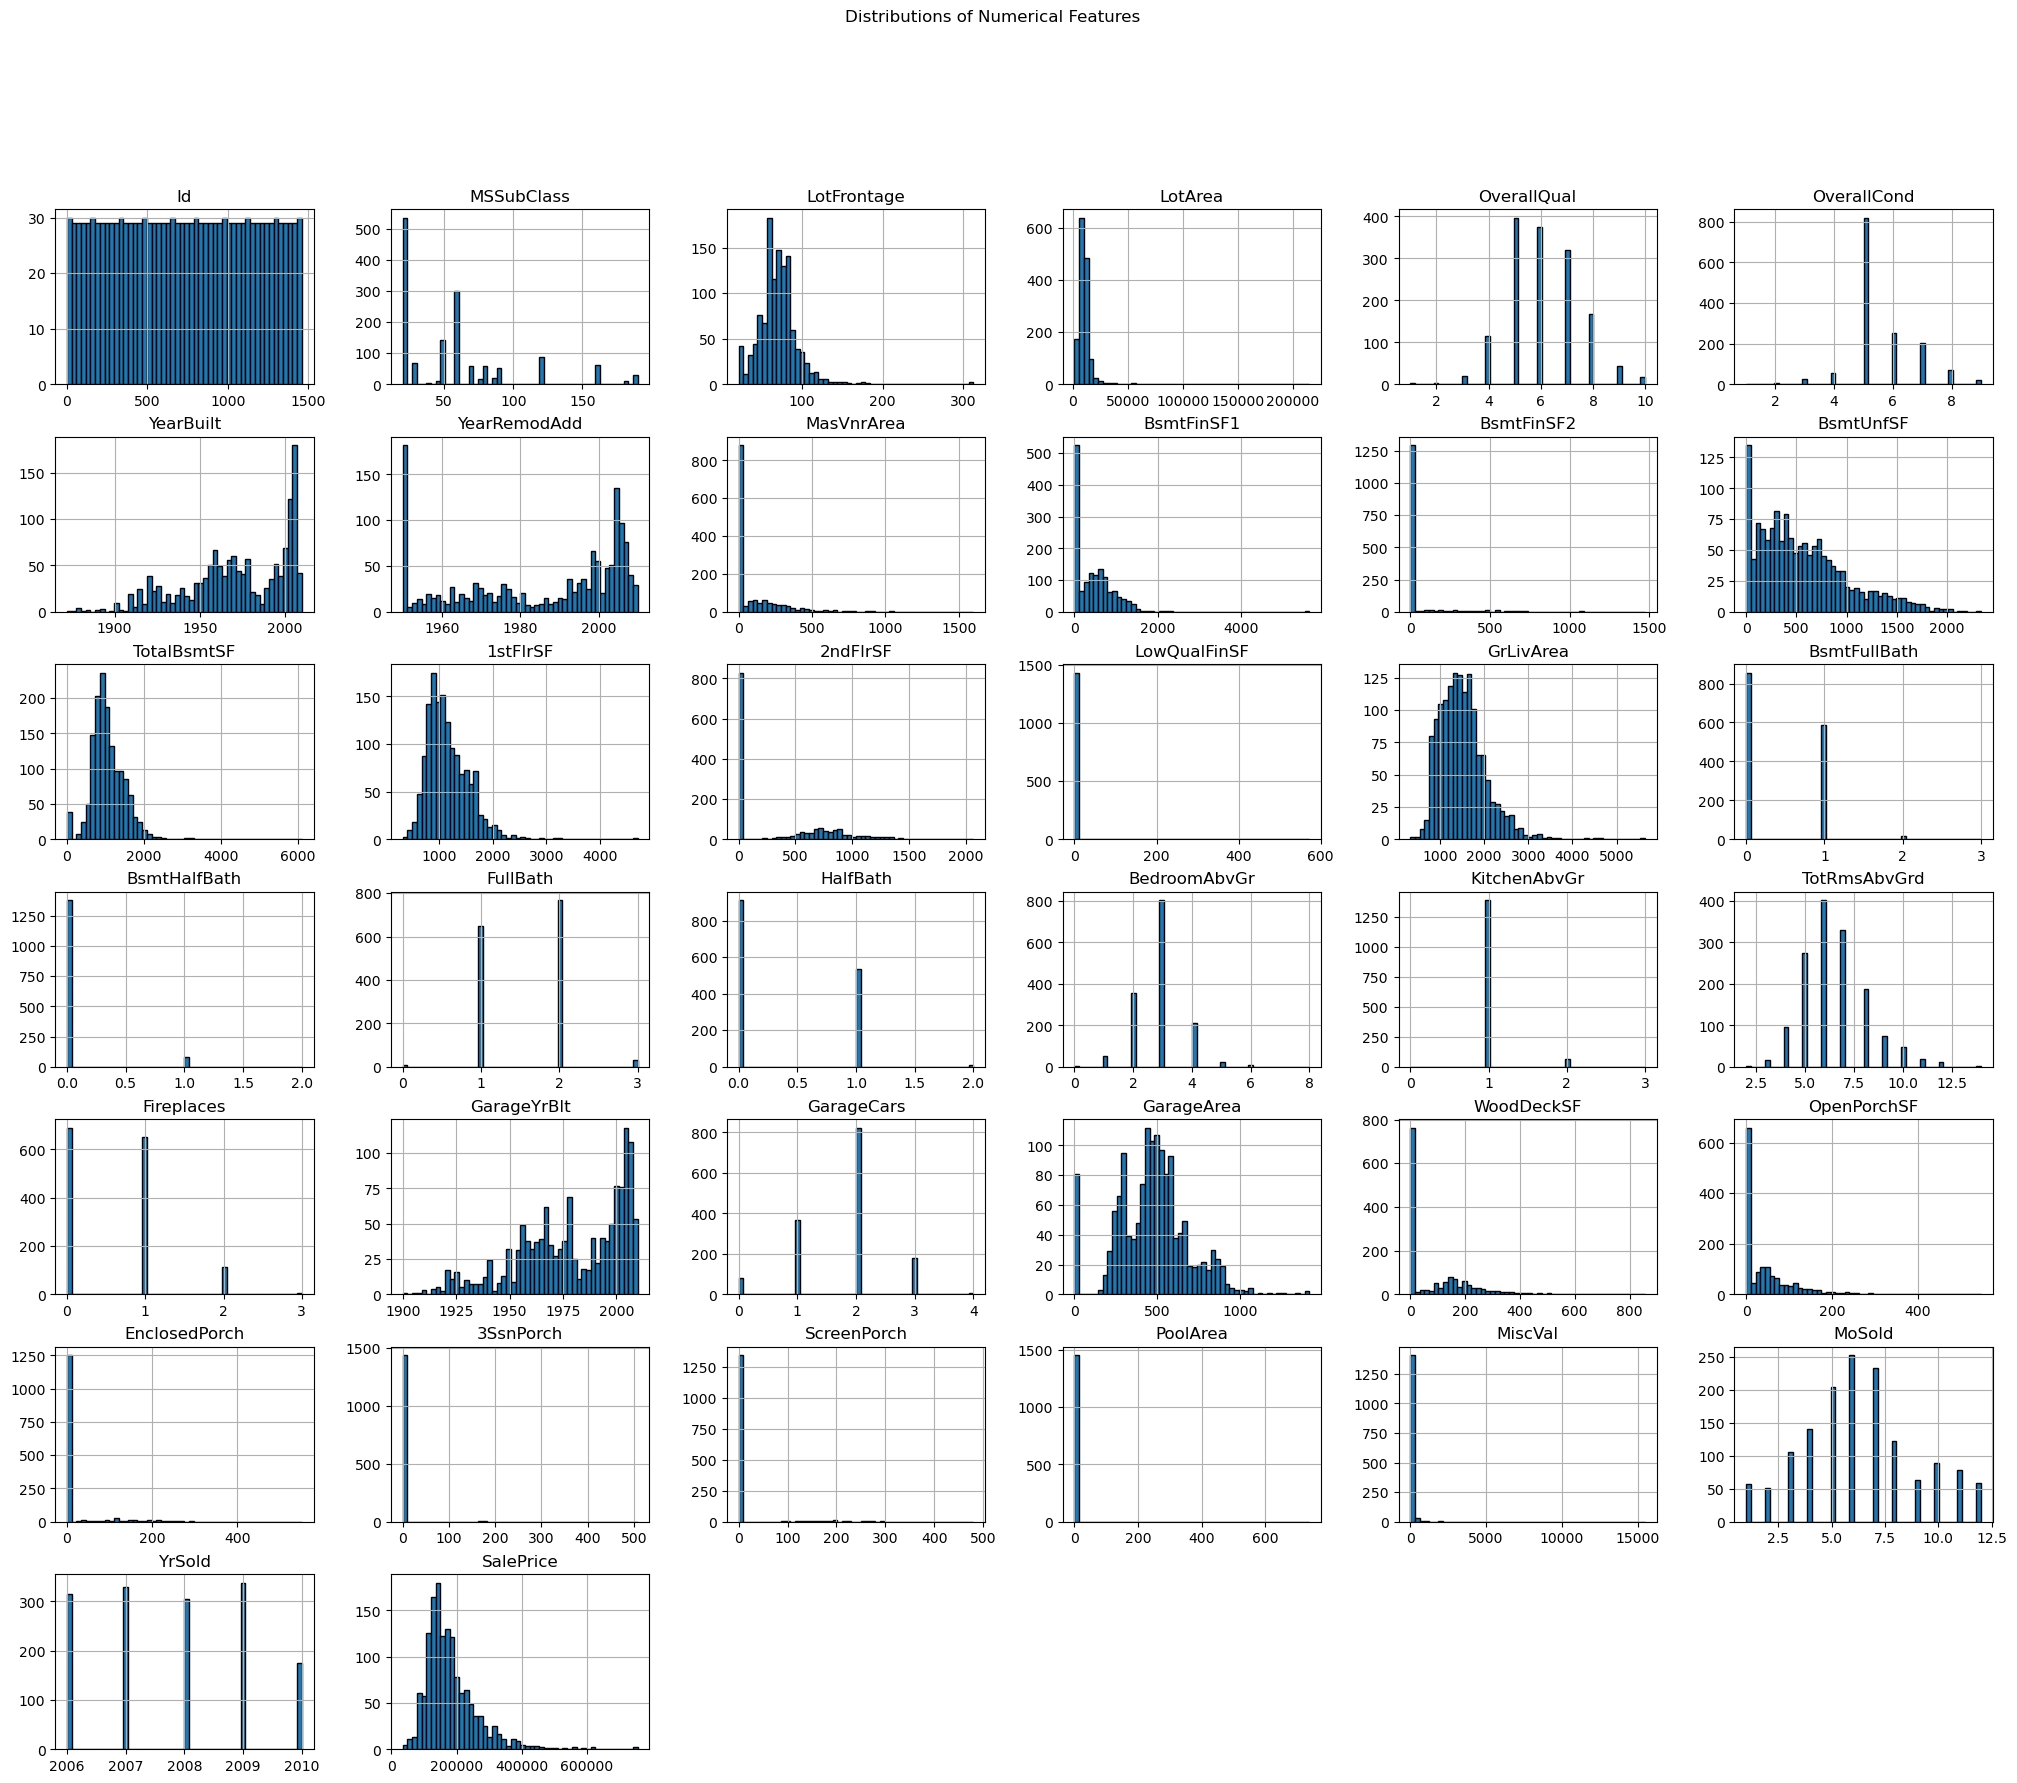

In [14]:
# Plot distributions of numerical features
train[numerical_features].hist(figsize=(25, 20), bins=50, edgecolor='black')
plt.suptitle("Distributions of Numerical Features", fontsize=12)
plt.show()

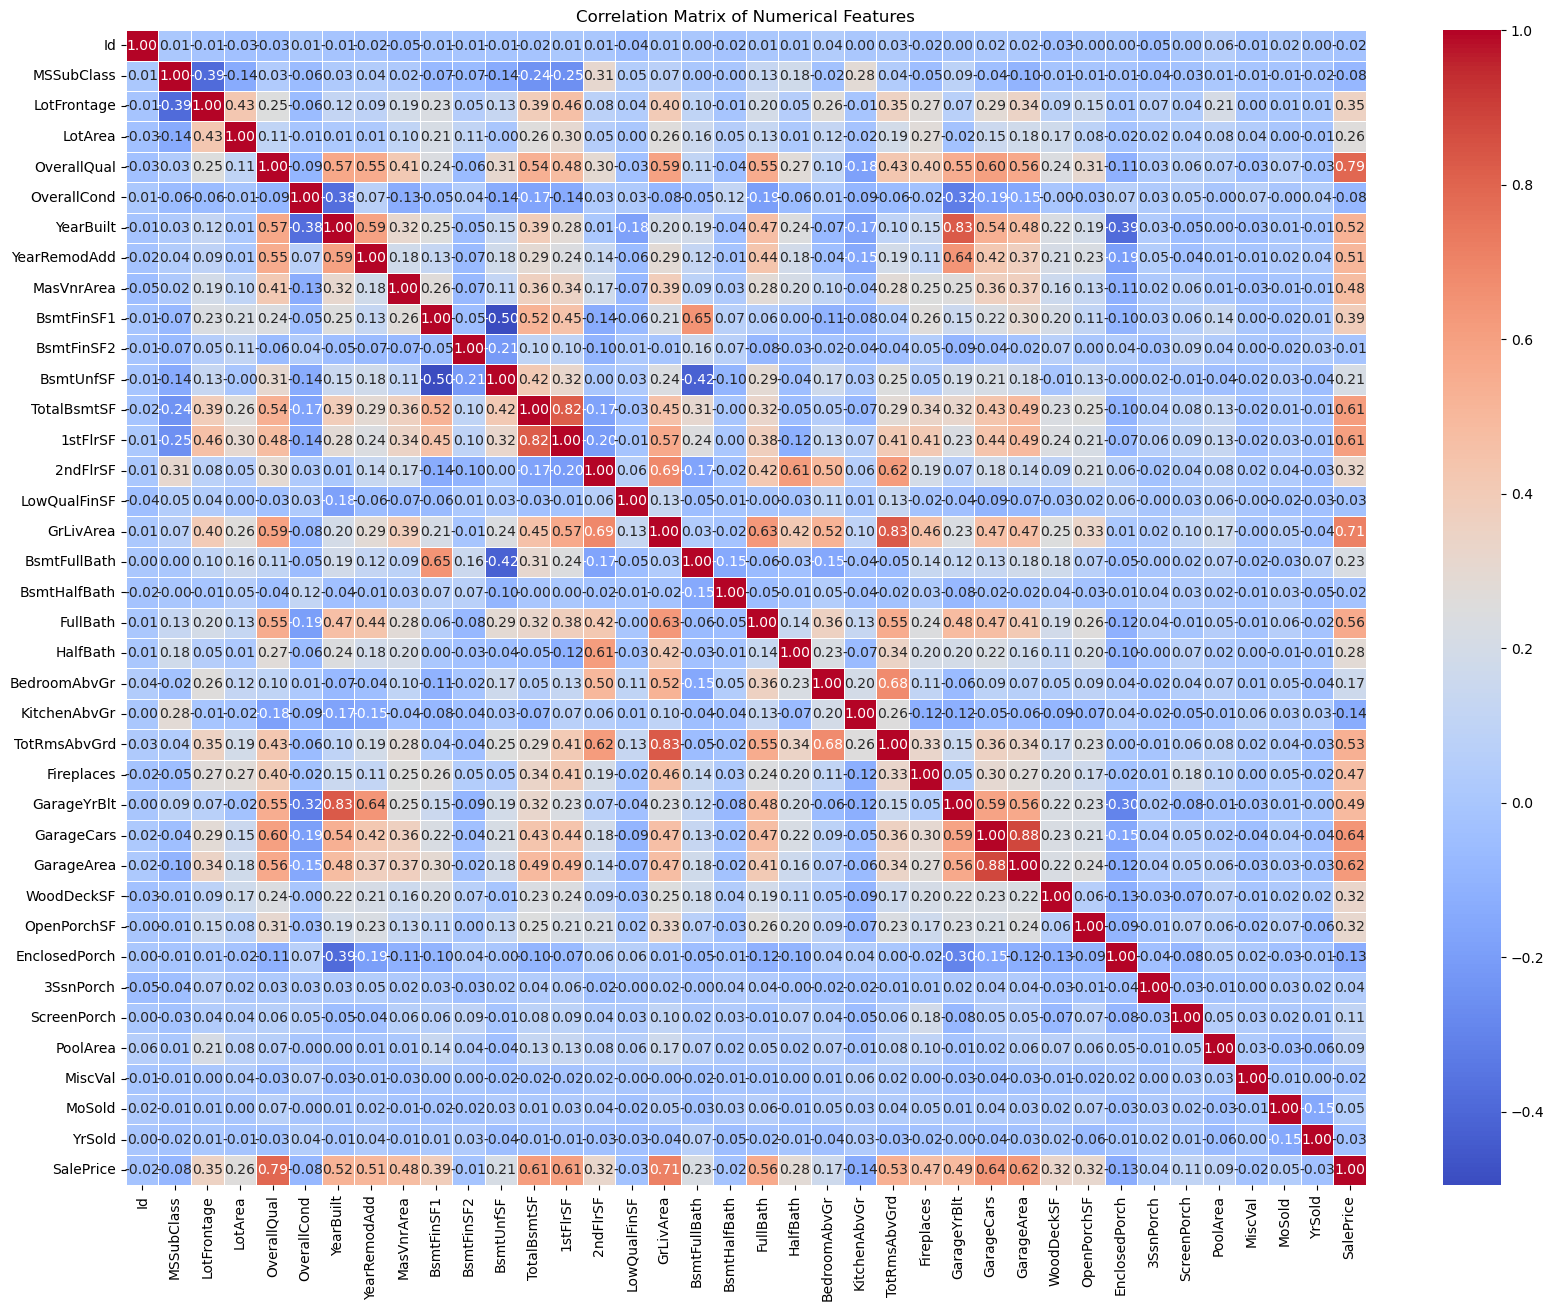

In [15]:
# Check for multicollinearity
correlation_matrix = train[numerical_features].corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [16]:
# Identify highly correlated features
threshold = 0.8
# Initialize an empty list to store high-correlation pairs
high_corr_pairs = []

# Loop through each pair of features in the correlation matrix
for feature_col in correlation_matrix.columns:
    for feature_row in correlation_matrix.columns:
        # Skip if it's the same feature (to avoid self-correlation)
        if feature_row == feature_col:
            continue
            
        # Get the absolute correlation value
        correlation_value = abs(correlation_matrix.loc[feature_row, feature_col])
        
        # If correlation is higher than the threshold, add to the list
        if correlation_value > threshold:
            high_corr_pairs.append((feature_row, feature_col, correlation_value))

# Convert to DataFrame for better visualization
high_corr_train = pd.DataFrame(high_corr_pairs, columns=["feature_row", "feature_col", "Correlation"])

# Remove duplicate pairs (since correlation matrix is symmetric)
high_corr_train = high_corr_train.sort_values(by="Correlation", ascending=False).drop_duplicates(subset=["Correlation"])

# Print high correlation pairs
print(high_corr_train)

    feature_row  feature_col  Correlation
6    GarageArea   GarageCars     0.882475
0   GarageYrBlt    YearBuilt     0.825667
3  TotRmsAbvGrd    GrLivArea     0.825489
1      1stFlrSF  TotalBsmtSF     0.819530


## Let's be sure to use a pipeline for our data in order to make our data cleaning and feature engineering processes repeatable, as well as easily changeable in the event we determine to use a different approach

In [18]:
# Drop highly correlated features
# train1: dropped high corr vars
train = train.drop(columns=["GarageArea", "GarageYrBlt", "GrLivArea", "TotalBsmtSF"])

In [19]:
# First, let's generate a list of the unique data types present in our training dataset
# Recall that a "set" is a tuple of non-repeating entries. So by passing our "dtypes" into
# a set, we end up with a list with one instance of each datatype
train_dtypes = list(set(train.dtypes))
train_dtypes

[dtype('float64'), dtype('int64'), dtype('O')]

In [20]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [21]:
# As we prepare our data for our pipeline transformations, we will need to specify to the transformers where our
# numeric data is located and where our categorical data is located. There are NUMEROUS ways to accomplish this task.
# One such method, shown below, is to separate our numeric and categorical variables into distinct objects, and then
# pass those objects directly to their respective transformers. This method is shown below.

# We need to generate a new object to contain our numeric training data, but this object should not include the "SalePrice"
# feature, which will be our predictor (i.e., 'y') variable when training our models
train_numeric_data = train.select_dtypes(include=[pd.Float64Dtype, pd.Int64Dtype]).drop(columns=['SalePrice'], axis=1)
train_numeric_data

/var/folders/75/0vf3n10n0tj6v1f4tbmjx4l00000gn/T/ipykernel_14361/1695953757.py:8: UserWarning: Instantiating Float64Dtype without any arguments.Pass a Float64Dtype instance to silence this warning.
  train_numeric_data = train.select_dtypes(include=[pd.Float64Dtype, pd.Int64Dtype]).drop(columns=['SalePrice'], axis=1)
/var/folders/75/0vf3n10n0tj6v1f4tbmjx4l00000gn/T/ipykernel_14361/1695953757.py:8: UserWarning: Instantiating Int64Dtype without any arguments.Pass a Int64Dtype instance to silence this warning.
  train_numeric_data = train.select_dtypes(include=[pd.Float64Dtype, pd.Int64Dtype]).drop(columns=['SalePrice'], axis=1)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,2,0,61,0,0,0,0,0,2,2008
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,2,298,0,0,0,0,0,0,5,2007
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,2,0,42,0,0,0,0,0,9,2008
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,3,0,35,272,0,0,0,0,2,2006
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,3,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,2,0,40,0,0,0,0,0,8,2007
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,2,349,0,0,0,0,0,0,2,2010
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,1,0,60,0,0,0,0,2500,5,2010
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,1,366,0,112,0,0,0,0,4,2010


In [22]:
# As we did above, we will generate a new object to house our categorical features, this time by passing all
# 'object' dtypes as our filter
train_cat_ord_data = train.select_dtypes(include=object)
train_cat_ord_data

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


### Before moving on to the pipeline (detailed below) let's ask ourselves a few questions:


1.   Could we benefit from segmenting some of the ordinal data in the "train_ord_cat_data" into a new object, then encoding them as ordinal data instead of using the one-hot-encoder as shown below?
2.   Are all of our numeric features (i.e., 'Id', 'YearBuilt', 'YearRemodAdded', 'YearSold') truly numeric in nature, or might they be more accurately considered categorical?

### Testing out some of these questions may lead to improvement over the performance of the model shown below...



In [24]:
ordinal_mapping = {
    "LotShape":    {"IR3":1, "IR2":2, "IR1":3, "Reg":4},
    "Utilities":   {"ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4},
    "LandSlope":   {"Sev":1, "Mod":2, "Gtl":3},
    "ExterQual":   {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
    "ExterCond":   {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
    "BsmtQual":    {"NA":1, "Po":2, "Fa":3, "TA":4, "Gd":5, "Ex":6},
    "BsmtCond":    {"NA":1, "Po":2, "Fa":3, "TA":4, "Gd":5, "Ex":6},
    "BsmtExposure":{"NA":1, "No":2, "Mn":3, "Av":4, "Gd":5},
    "BsmtFinType1":{"NA":1, "Unf":2, "LwQ":3, "Rec":4, "BLQ":5, "ALQ":6, "GLQ":7},
    "BsmtFinType2":{"NA":1, "Unf":2, "LwQ":3, "Rec":4, "BLQ":5, "ALQ":6, "GLQ":7},
    "HeatingQC":   {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
    "CentralAir":  {"N":1, "Y":2},
    "KitchenQual": {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
    "Functional":  {"Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8},
    "FireplaceQu": {"NA":1, "Po":2, "Fa":3, "TA":4, "Gd":5, "Ex":6},
    "GarageFinish":{"NA":1, "Unf":2, "RFn":3, "Fin":4},
    "GarageQual":  {"NA":1, "Po":2, "Fa":3, "TA":4, "Gd":5, "Ex":6},
    "GarageCond":  {"NA":1, "Po":2, "Fa":3, "TA":4, "Gd":5, "Ex":6},
    "PavedDrive":  {"N":1, "P":2, "Y":3},
    "PoolQC":      {"NA":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
    "Fence":       {"NA":1, "MnWw":2, "GdWo":3, "MnPrv":4, "GdPrv":5}
}

for col, mapping in ordinal_mapping.items():
    if col in train_cat_ord_data.columns:
        train_cat_ord_data[col] = train_cat_ord_data[col].map(mapping)




In [25]:
train_cat_ord_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1460 non-null   object 
 1   Street         1460 non-null   object 
 2   Alley          91 non-null     object 
 3   LotShape       1460 non-null   int64  
 4   LandContour    1460 non-null   object 
 5   Utilities      1460 non-null   int64  
 6   LotConfig      1460 non-null   object 
 7   LandSlope      1460 non-null   int64  
 8   Neighborhood   1460 non-null   object 
 9   Condition1     1460 non-null   object 
 10  Condition2     1460 non-null   object 
 11  BldgType       1460 non-null   object 
 12  HouseStyle     1460 non-null   object 
 13  RoofStyle      1460 non-null   object 
 14  RoofMatl       1460 non-null   object 
 15  Exterior1st    1460 non-null   object 
 16  Exterior2nd    1460 non-null   object 
 17  MasVnrType     588 non-null    object 
 18  ExterQua

In [26]:
# We will establish separate pipelines for the numeric and categorical data in our dataset.
# The types of feature engineering and imputation strategies I've chosen are by no means the best avaiable,
# they are simply a starting point. Please feel encouraged to experiment - and report on the results of
# those experiments in your A2 write-up.

num_pipeline = sklearn.pipeline.Pipeline(
    steps = [('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler())]
)

cat_pipeline = sklearn.pipeline.Pipeline(
    steps = [('cat_imputer', SimpleImputer(strategy='most_frequent')),
             ("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

# The ColumnTransformer allows us to combine multiple pipelines into one new object, so when we go to pass our
# unaltered training data into our transformaiton pipeline, we can accomplish the task using one "fit_transform()"
# method.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, train_numeric_data.columns),
        ('cat', cat_pipeline, train_cat_ord_data.columns),
    ]
)

In [27]:
# We can use the fit_transform() method to enact our data pipeline on our training data
processed_train_data = preprocessor.fit_transform(train)

In [28]:
# We've generated a 'sparse' matrix, which has special data compression properties in Python
processed_train_data

<1460x284 sparse matrix of type '<class 'numpy.float64'>'
	with 110960 stored elements in Compressed Sparse Row format>

In [29]:
# We can't pass back the column names from the original 'train' DF; we've generated many
# new columns as the result of our one-hot-encoding. Nevertheless, we can still generate
# a dataframe in order to help visualize the data transformations we've undertaken
pd.DataFrame.sparse.from_spmatrix(processed_train_data, index=None, columns=None)

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
0,-1.730865,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.728492,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.726120,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.723747,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.721374,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.721374,0.073375,-0.357114,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.570750,-0.973018,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,1.723747,-0.872563,0.687385,0.266407,-0.071836,0.381743,0.222975,0.151865,0.087911,0.759659,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,1.726120,0.309859,-0.175462,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.570750,-0.369871,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,1.728492,-0.872563,-0.084636,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.570750,-0.865548,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
# We can generate a list of the newly created one_hot_encoded features using the code snippet below
new_one_hot_features = preprocessor.transformers_[1][1]['encoder'].get_feature_names_out(train_cat_ord_data.columns)
new_one_hot_features

array(['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl',
       'Alley_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3',
       'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS',
       'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub',
       'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside',
       'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev',
       'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_

### Below, I will fit a Lasso Regression model in order to demonstrate the process. For your A2 assignment, please be sure the reference the assignment guidelines, which require you to test a variety of 'alpha' values, finding the best resultant value for your modeling work.

Best alpha: 24.4205, RMSE: 29712.6831


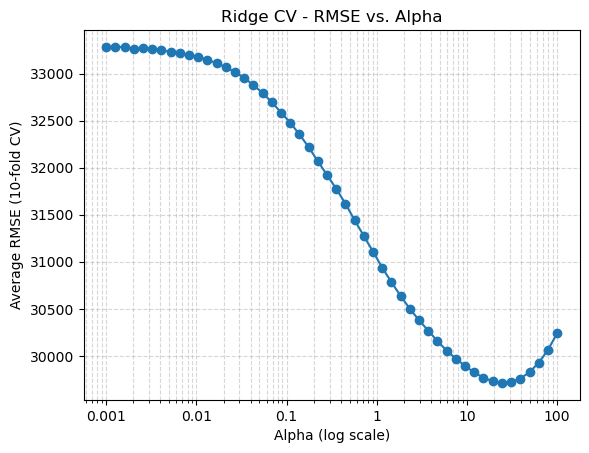

In [244]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# 生成从 10^-3 到 10^2 共 50 个 alpha 值
alphas = np.logspace(-3, 2, 50)
test_scores = []

for alpha in alphas:
    clf = Ridge(alpha=alpha)
    neg_mse = cross_val_score(clf,
                              processed_train_data,
                              train['SalePrice'],
                              cv=10,
                              scoring='neg_mean_squared_error')
    rmse = np.sqrt(-neg_mse)
    test_scores.append(rmse.mean())

# 找到使 RMSE 最小的 alpha
best_index = np.argmin(test_scores)
best_alpha = alphas[best_index]
best_score = test_scores[best_index]
print(f"Best alpha: {best_alpha:.4f}, RMSE: {best_score:.4f}")

# 绘制 alpha 与 RMSE 之间的关系
plt.plot(alphas, test_scores, marker='o')
plt.xscale('log')  # 使用对数刻度
plt.xlabel("Alpha (log scale)")
plt.ylabel("Average RMSE (10-fold CV)")
plt.title("Ridge CV - RMSE vs. Alpha")

# 设置刻度(可根据需要调整或增加更多刻度)
tick_values = [0.001, 0.01, 0.1, 1, 10, 100]
plt.xticks(tick_values, tick_values)

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()


In [271]:
# Generate an instance of your model; be sure to specify the alpha value, which will control the regularization
# term applied to the loss function
lasso_reg = Ridge(alpha=0.001, max_iter=100000)
lasso_reg.fit(processed_train_data, train['SalePrice'])

Ridge(alpha=0.001, max_iter=100000)

In [273]:
# We can view an array of the coefficients calculated based on our Lasso Regression fit
lasso_reg.coef_

array([ 4.75010038e+02, -2.29650810e+03,  8.85464368e+02,  7.20105158e+03,
        8.90903321e+03,  6.40532378e+03,  9.51736103e+03,  2.12567914e+03,
        3.07900614e+03,  1.54409965e+04,  3.97227523e+03,  6.44521261e+03,
        1.95970964e+04,  2.82912440e+04,  8.61456299e+01,  6.65205648e+02,
       -2.11417094e+02,  2.12701004e+03,  7.44626745e+02, -3.17528525e+03,
       -2.80184831e+03,  2.48460949e+03,  1.57761596e+03,  4.57913902e+03,
        1.96318224e+03,  3.89930792e+02,  1.95949720e+02,  9.28370635e+02,
        1.94315309e+03,  3.93594645e+03,  1.74214669e+03, -1.32048874e+03,
       -6.75896243e+02, -2.20612453e+04,  1.29870522e+04,  3.83464153e+03,
        5.37264361e+03, -1.33092095e+02, -1.59135847e+04,  1.59135847e+04,
       -2.07705424e+02,  2.07705423e+02, -2.81589177e+03,  1.88310293e+03,
        2.02436603e+03, -1.09157720e+03, -2.00637031e+03,  7.07623231e+03,
       -9.84795102e+03,  4.77808902e+03,  1.88572610e+04, -1.88572610e+04,
        3.66497282e+03,  

In [275]:
# Generate a list of the features in our transformed training dataset;
# This list requires that the features be passed back in the same order the model was fitted
feature_list = list(train_numeric_data.columns) + list(new_one_hot_features)

In [277]:
# Let's form a new DF that has the feature labels and coefficient values for our fitted model
# We will also sort the values
train_coef_df = pd.DataFrame(lasso_reg.coef_, index=feature_list, columns=['coef_value'])
train_coef_df.sort_values(by='coef_value')

,coef_value
RoofMatl_ClyTile,-597649.609027
Condition2_PosN,-194676.697210
GarageCond_Ex,-88333.048998
Condition2_RRAe,-52522.796619
PoolQC_Fa,-41211.688005
...,...
Condition2_PosA,84326.875400
GarageQual_Ex,102198.375071
RoofMatl_WdShngl,114181.424761
RoofMatl_Metal,121933.000132


In [279]:
# Did the Lasso Regression with my chosen alpha value lead to the elimination
# (i.e. reduction towards zero) of many coefficients?
train_coef_df[(train_coef_df['coef_value']>= -5) & (train_coef_df['coef_value']<= 5)]

,coef_value


### Below we demonstrate how to apply the data transformers to the test data, generate predictions and then produce a Kaggle submission-ready .csv file

In [282]:
# Apply the already created pipeline transformer to the test dataset
test_rdy = preprocessor.transform(test)
test_rdy.shape

(1459, 284)

In [284]:
# We already 'fit' our model on the training data, so now that the test dataset is in the proper format
# we can apply the .predict() method to generate SalePrice predictions on our test dataset
pred = lasso_reg.predict(test_rdy)

In [286]:
# Generate a DF object that will house our predictions (which currently reside in an array titled 'pred')
df = pd.DataFrame(index=np.arange(len(test)), columns=['Id', 'SalePrice'])

In [288]:
# Copy in the 'Id' column from the test dataset
# Copy in the predictions to the 'SalePrice' column
df['Id'] = test['Id']
df['SalePrice'] = pred
# View the output
df

,Id,SalePrice
0,1461,108759.636365
1,1462,154180.216717
2,1463,187148.808290
3,1464,201452.279698
4,1465,203233.021889
...,...,...
1454,2915,82242.076456
1455,2916,81104.551038
1456,2917,181076.322024
1457,2918,109379.844452


In [290]:
# Let's get a quick understanding of the statistical descriptive characteristics of our
# predictions
df.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,180948.000277
std,421.321334,80496.469752
min,1461.000000,4807.210915
25%,1825.500000,127976.996364
50%,2190.000000,162457.558000
75%,2554.500000,215683.039120
max,2919.000000,754719.938564


<Axes: ylabel='Frequency'>

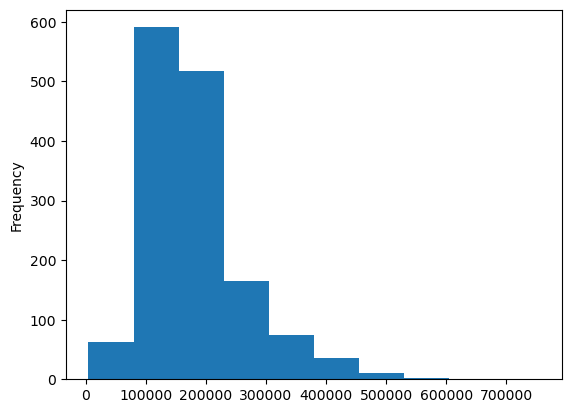

In [292]:
# Plot a histogram of the SalePrice column
df['SalePrice'].plot.hist()

In [294]:
# Use the .to_csv() method in Pandas to output our results to a .csv file for submission to Kaggle
df.to_csv('./simple_lasso_pred.csv', index=False)